## Grandient Boosting Modeling for Math ##

The models are:
- CatBoost
- XGBoost
- LightGBM
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import warnings 
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [Data_Integration.ipynb](../processing/Data_Integration.ipynb)

In [3]:
df = pd.read_csv('../processing/DATA_Texas_District_v2.csv', sep=',', header=0)
print(df.shape)

(955, 90)


**Get dummies for categorical feature `Locale`**

In [4]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(955, 101)


**Split data**

In [5]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Tested Reading G3 Diff',
            '% Tested Reading G4 Diff',
            '% Tested Reading G5 Diff',
            '% Tested Reading G6 Diff',
            '% Tested Reading G7 Diff',
            '% Tested Reading G8 Diff',
            'District #', 'County #']

df['Label'] = df['Label_Math'].apply(lambda x: 0 if x == -1
                                             else 1 if x == 0
                                             else 2)

y = df['Label'].values
X = df.drop(columns=labels + cols_drop + ['Label']).copy()
columns = df.drop(columns=labels + cols_drop + ['Label']).columns.to_list()
categorical_cols = [c for c in columns if 'Locale' in c]
categorical_cols_idx = [columns.index(c) for c in columns if 'Locale' in c]
numerical_cols = [c for c in columns if c not in categorical_cols]

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)

(955, 90)


In [6]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,166,41
1,1,412,103
2,2,186,47


### Experiment with the Feature Sets selected from [Feature_Selection_Math.ipynb](../processing/Feature_Selection_Math.ipynb) ###

In [7]:
feature_selected = pd.read_csv('../Processing/Feature_Selection_Math_Results.csv', sep=',', header=0)
feature_selected = feature_selected.groupby('feature', as_index=False).agg({'selected': 'sum'})
n_selected_by = [4, 5, 6, 0]

for i, n in enumerate(n_selected_by):
    n_feat = len(columns) if n == 0 else feature_selected[feature_selected['selected']>=n].shape[0]
    n_sel = 'from No reduction' if n ==0 else 'selected by '+str(n)+' or more selection methods'
    print('Feature Set {}: n={} {}'.format(i+1, n_feat, n_sel))

Feature Set 1: n=51 selected by 4 or more selection methods
Feature Set 2: n=32 selected by 5 or more selection methods
Feature Set 3: n=15 selected by 6 or more selection methods
Feature Set 4: n=90 from No reduction


**n iteration for models**

In [8]:
def get_n_iter (param_grid):
    n_iter_ratio = 0.2
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter *= n_iter_ratio

    return int(n_iter)

### Modeling ###

In [9]:
rounds = 20

In [10]:
def model_report(estimator, param_grid, name, fit_params):
    result = pd.DataFrame()
    avg = 'weighted'
    cv=5
    
    n_iter=get_n_iter(param_grid)
    print('{} n_iter: {:0.0f}'.format(name, n_iter))     
    if name == 'CatBoost': n_iter=100
       
    for n in n_selected_by:
        if n == 0:
            features = columns 
            method = "No Reduction"
        else:
            features = feature_selected[feature_selected['selected']>=n]['feature'].to_list()
            method = str(n)+' or more'
            
        X_train2 = X_train.loc[:, features].copy()
        X_test2 = X_test.loc[:, features].copy()                        
        
        categorical_cols_inx=[features.index(f) for f in features if f in categorical_cols]
        if len(categorical_cols_inx) > 0:
            if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols_inx
            if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols_inx
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols_inx})
            if (name == 'XGBoost'):
                X_train2=X_train2.astype({features[c]: 'category' for c in categorical_cols_inx})
                X_test2=X_test2.astype({features[c]: 'category' for c in categorical_cols_inx})
        else: 
            if (name == 'LightGBM'): fit_params['categorical_feature']=None
            if (name == 'CatBoost'): fit_params['cat_features']=None
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})
              
        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'HistGB': 
            grid.fit(X_train2, y_train)
        elif name == 'LightGBM':
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
        else:
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
       
        if name == 'XGBoost': grid.best_estimator_.save_model("categorical-model.json")
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred, average=avg),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [11]:
results = pd.DataFrame()

**CatBoost**

In [12]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
'depth': [3, 6, 9],
'min_data_in_leaf': [1, 5, 10],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, 
                               loss_function='MultiClass', eval_metric="MultiClass", one_hot_max_size=4, border_count=254)
                               
result_report=model_report(estimator, params, 'CatBoost', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 432
CPU times: total: 22.8 s
Wall time: 56min 20s


**XGBoost**

In [13]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

# fit_params = {'early_stopping_rounds': rounds,
#               'eval_metric': 'mlogloss'}

estimator = xgboost.XGBClassifier(seed=random_state, objective='multi:softproba', eval_metric='mlogloss', use_label_encoder=False, verbosity=0,
                                  num_class=3, tree_method="hist", early_stopping_rounds=rounds, enable_categorical=True, max_cat_to_onehot=4)

result_report=model_report(estimator, params, 'XGBoost', {})
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 777
[0]	validation_0-mlogloss:1.09497
[1]	validation_0-mlogloss:1.09139
[2]	validation_0-mlogloss:1.08786
[3]	validation_0-mlogloss:1.08439
[4]	validation_0-mlogloss:1.08098
[5]	validation_0-mlogloss:1.07762
[6]	validation_0-mlogloss:1.07431
[7]	validation_0-mlogloss:1.07105
[8]	validation_0-mlogloss:1.06759
[9]	validation_0-mlogloss:1.06431
[10]	validation_0-mlogloss:1.06133
[11]	validation_0-mlogloss:1.05819
[12]	validation_0-mlogloss:1.05515
[13]	validation_0-mlogloss:1.05222
[14]	validation_0-mlogloss:1.04923
[15]	validation_0-mlogloss:1.04639
[16]	validation_0-mlogloss:1.04346
[17]	validation_0-mlogloss:1.04071
[18]	validation_0-mlogloss:1.03799
[19]	validation_0-mlogloss:1.03521
[20]	validation_0-mlogloss:1.03256
[21]	validation_0-mlogloss:1.02986
[22]	validation_0-mlogloss:1.02719
[23]	validation_0-mlogloss:1.02462
[24]	validation_0-mlogloss:1.02199
[25]	validation_0-mlogloss:1.01961
[26]	validation_0-mlogloss:1.01716
[27]	validation_0-mlogloss:1.01471
[28]	valid

[32]	validation_0-mlogloss:1.01223
[33]	validation_0-mlogloss:1.01001
[34]	validation_0-mlogloss:1.00781
[35]	validation_0-mlogloss:1.00576
[36]	validation_0-mlogloss:1.00362
[37]	validation_0-mlogloss:1.00150
[38]	validation_0-mlogloss:0.99952
[39]	validation_0-mlogloss:0.99746
[40]	validation_0-mlogloss:0.99542
[41]	validation_0-mlogloss:0.99349
[42]	validation_0-mlogloss:0.99149
[43]	validation_0-mlogloss:0.98961
[44]	validation_0-mlogloss:0.98766
[45]	validation_0-mlogloss:0.98574
[46]	validation_0-mlogloss:0.98393
[47]	validation_0-mlogloss:0.98205
[48]	validation_0-mlogloss:0.98017
[49]	validation_0-mlogloss:0.97842
[50]	validation_0-mlogloss:0.97661
[51]	validation_0-mlogloss:0.97490
[52]	validation_0-mlogloss:0.97311
[53]	validation_0-mlogloss:0.97143
[54]	validation_0-mlogloss:0.96966
[55]	validation_0-mlogloss:0.96805
[56]	validation_0-mlogloss:0.96634
[57]	validation_0-mlogloss:0.96474
[58]	validation_0-mlogloss:0.96305
[59]	validation_0-mlogloss:0.96149
[60]	validation_0-ml

[117]	validation_0-mlogloss:0.88331
[118]	validation_0-mlogloss:0.88252
[119]	validation_0-mlogloss:0.88172
[120]	validation_0-mlogloss:0.88095
[121]	validation_0-mlogloss:0.88032
[122]	validation_0-mlogloss:0.87950
[123]	validation_0-mlogloss:0.87879
[124]	validation_0-mlogloss:0.87798
[125]	validation_0-mlogloss:0.87731
[126]	validation_0-mlogloss:0.87651
[127]	validation_0-mlogloss:0.87583
[128]	validation_0-mlogloss:0.87509
[129]	validation_0-mlogloss:0.87432
[130]	validation_0-mlogloss:0.87354
[131]	validation_0-mlogloss:0.87297
[132]	validation_0-mlogloss:0.87222
[133]	validation_0-mlogloss:0.87151
[134]	validation_0-mlogloss:0.87076
[135]	validation_0-mlogloss:0.87018
[136]	validation_0-mlogloss:0.86944
[137]	validation_0-mlogloss:0.86882
[138]	validation_0-mlogloss:0.86810
[139]	validation_0-mlogloss:0.86744
[140]	validation_0-mlogloss:0.86685
[141]	validation_0-mlogloss:0.86621
[142]	validation_0-mlogloss:0.86556
[143]	validation_0-mlogloss:0.86487
[144]	validation_0-mlogloss:

**LightGBM**

In [14]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(random_state=random_state, objective="multiclass", metric="multi_logloss", verbosity=-1, silent=True, force_col_wise=True,
                               num_class=3, is_unbalance=True, max_cat_threshold=32)
                               
result_report=model_report(estimator, params, 'LightGBM', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 777
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.957254
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.920452
[3]	valid_0's multi_logloss: 0.895849
[4]	valid_0's multi_logloss: 0.879158
[5]	valid_0's multi_logloss: 0.865249
[6]	valid_0's multi_logloss: 0.858008
[7]	valid_0's multi_logloss: 0.851434
[8]	valid_0's multi_logloss: 0.847631
[9]	valid_0's multi_logloss: 0.84268
[10]	valid_0's multi_logloss: 0.84268
[11]	valid_0's multi_logloss: 0.84268
[12]	valid_0's multi_logloss: 0.84268
[13]	valid_0's multi_logloss: 0.84268
[14]	valid_0's multi_logloss: 0.84268
[15]	valid_0's multi_logloss: 0.84268
[16]	valid_0's multi_logloss: 0.84268
[17]	valid_0's multi_logloss: 0.84268
[18]	valid_0's multi_logloss: 0.84268
[19]	valid_0's multi_logloss: 0.84268
[20]	valid_0's multi_logloss: 0.84268
[21]	valid_0's mult

**HistGradientBoosting**

In [15]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, 'HistGB', {})
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 432
CPU times: total: 48.2 s
Wall time: 4min 58s


## Result ##

In [16]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,MCC,F1,best_params
12,HistGB,4 or more,51,0.664921,0.416281,0.620974,"{'min_samples_leaf': 10, 'max_leaf_nodes': 64,..."
0,CatBoost,4 or more,51,0.664921,0.413879,0.628741,"{'random_strength': 5, 'min_data_in_leaf': 5, ..."
3,CatBoost,No Reduction,90,0.643979,0.376758,0.586391,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
10,LightGBM,6 or more,15,0.643979,0.370947,0.612515,"{'reg_lambda': 10, 'reg_alpha': 0, 'n_estimato..."
8,LightGBM,4 or more,51,0.628272,0.352696,0.534764,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."
11,LightGBM,No Reduction,90,0.628272,0.352696,0.534764,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."
9,LightGBM,5 or more,32,0.633508,0.350113,0.574868,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat..."
1,CatBoost,5 or more,32,0.628272,0.336793,0.595349,"{'random_strength': 5, 'min_data_in_leaf': 5, ..."
15,HistGB,No Reduction,90,0.623037,0.334739,0.543166,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,..."
4,XGBoost,4 or more,51,0.623037,0.333338,0.544464,"{'n_estimators': 200, 'min_child_weight': 0.00..."


In [17]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
LightGBM,4
CatBoost,3
HistGB,2
XGBoost,1


In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
15,1
32,2
51,4
90,3


**Accuracy, MCC and F1 Score**

In [19]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

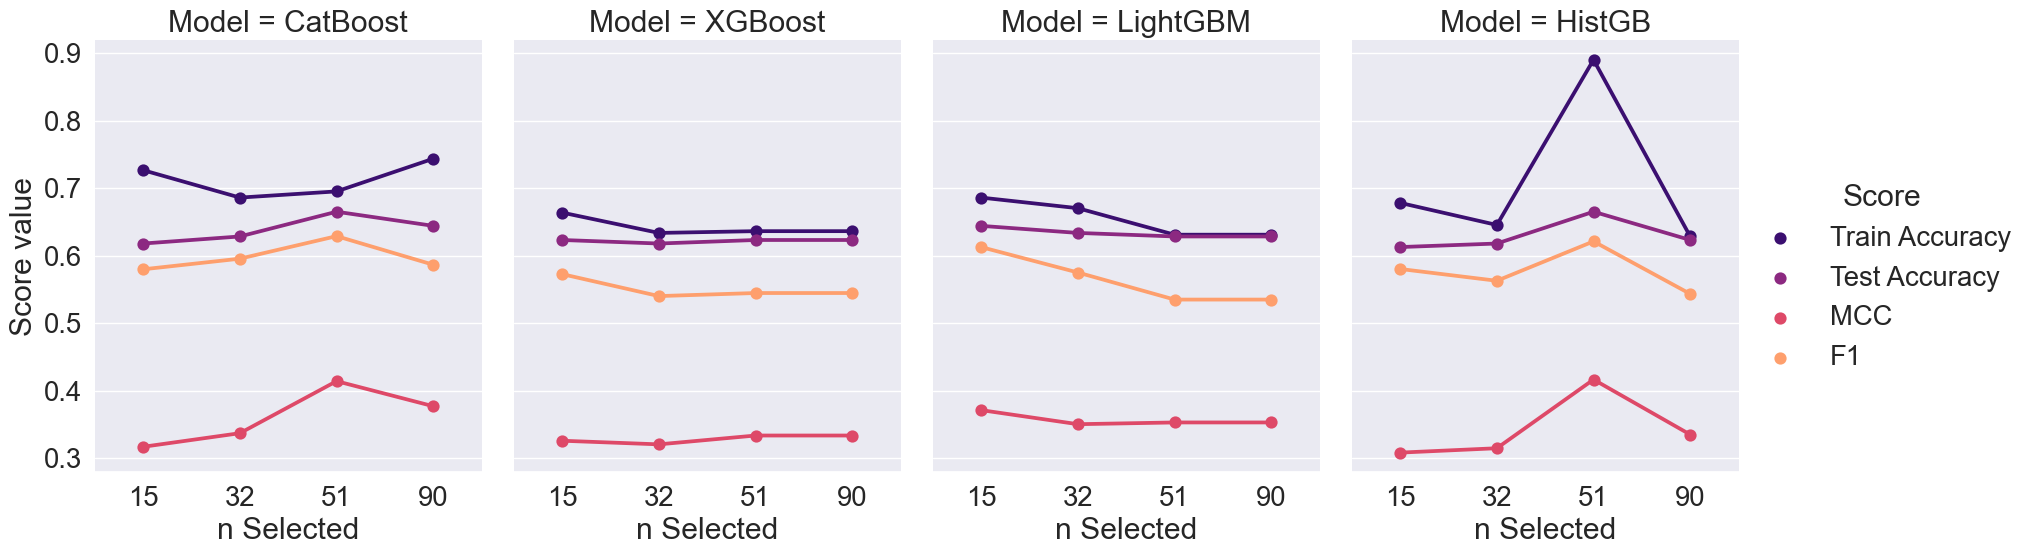

In [20]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [32]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % len(models) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

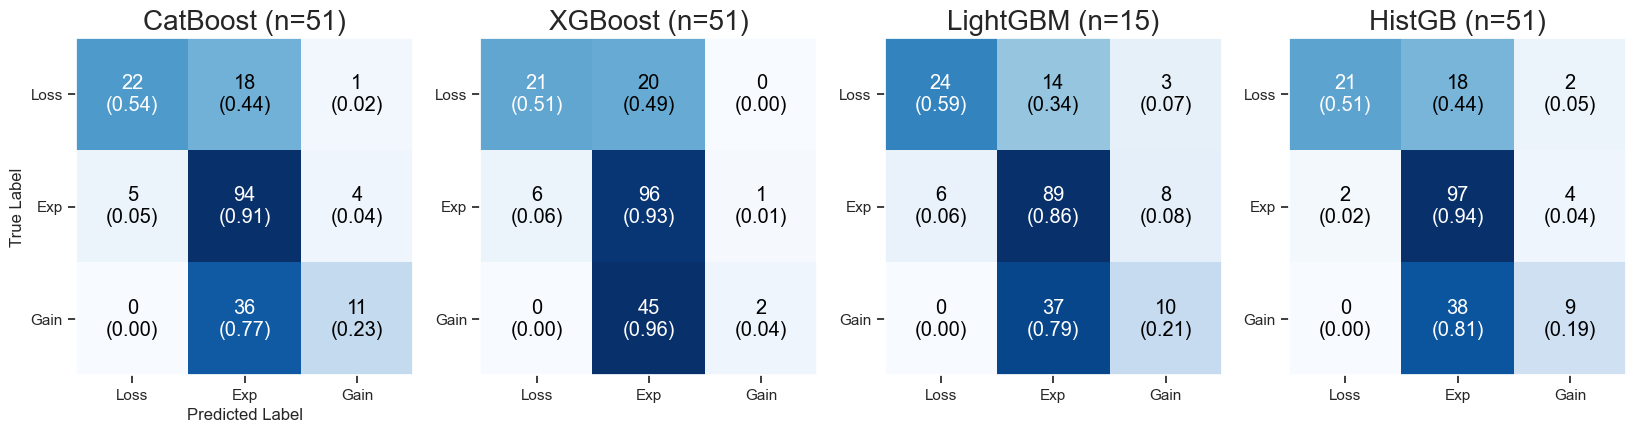

In [33]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

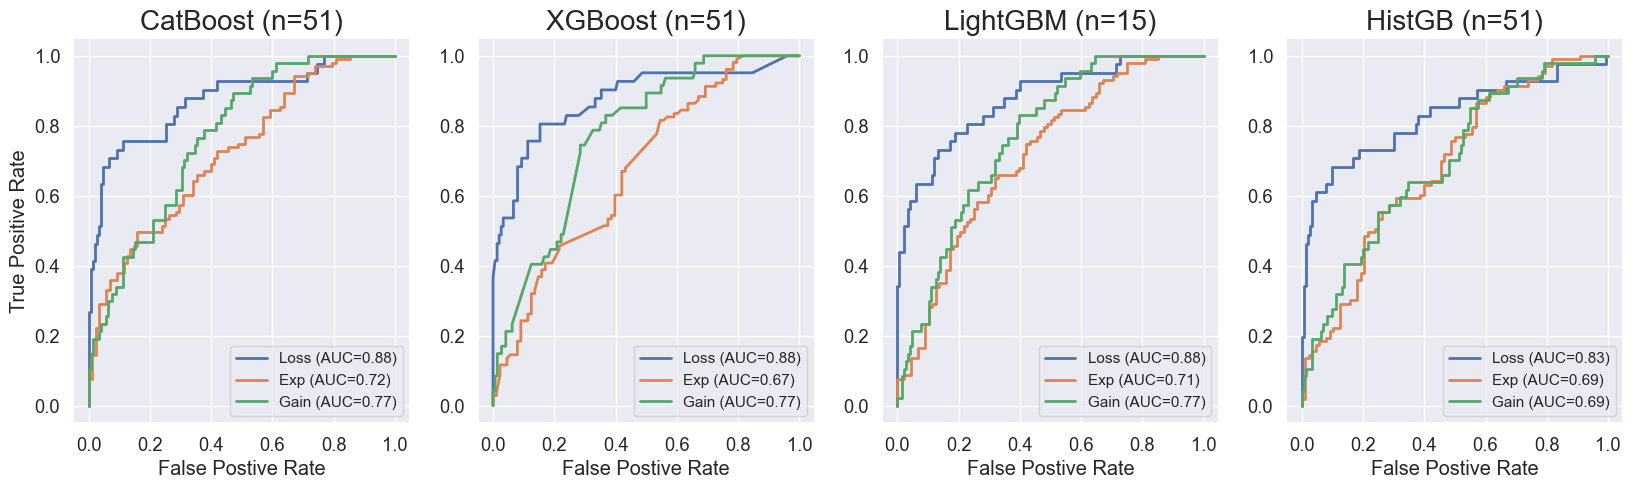

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+1), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

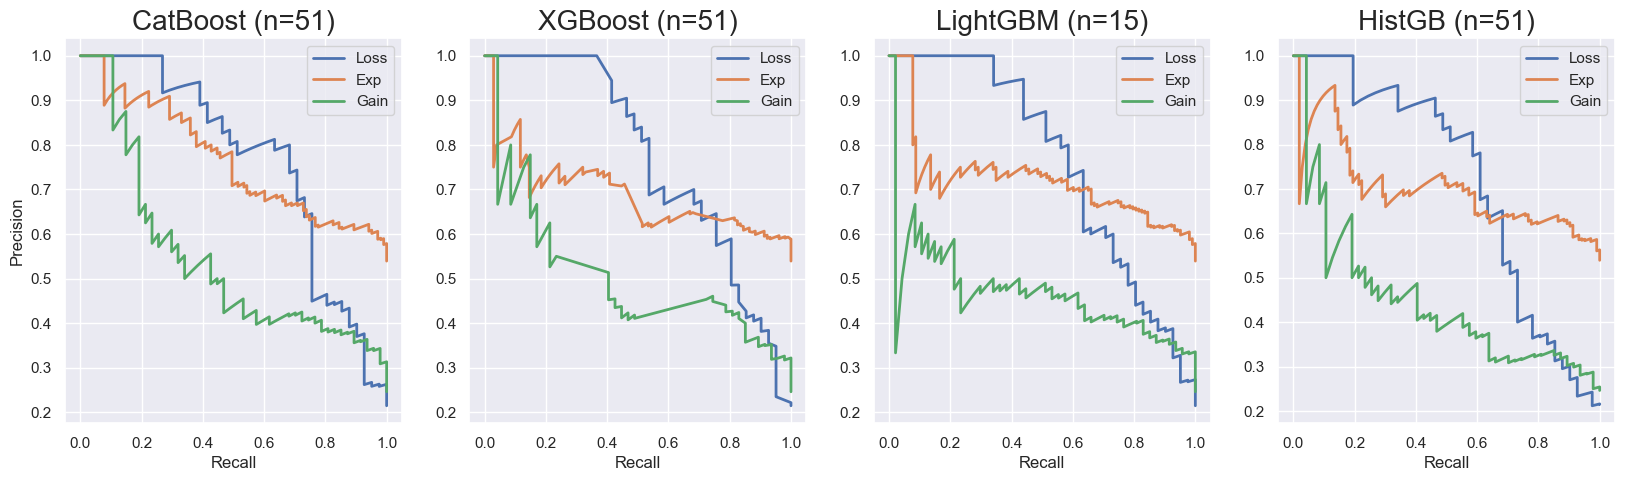

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+1)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()

In [36]:
for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    print(title, '\n', results.loc[idx, 'classification_report'])

CatBoost (n=51) 
               precision    recall  f1-score   support

           0       0.81      0.54      0.65        41
           1       0.64      0.91      0.75       103
           2       0.69      0.23      0.35        47

    accuracy                           0.66       191
   macro avg       0.71      0.56      0.58       191
weighted avg       0.69      0.66      0.63       191

XGBoost (n=51) 
               precision    recall  f1-score   support

           0       0.78      0.51      0.62        41
           1       0.60      0.93      0.73       103
           2       0.67      0.04      0.08        47

    accuracy                           0.62       191
   macro avg       0.68      0.50      0.47       191
weighted avg       0.65      0.62      0.54       191

LightGBM (n=15) 
               precision    recall  f1-score   support

           0       0.80      0.59      0.68        41
           1       0.64      0.86      0.73       103
           2       0.4

In [38]:
results.sort_values(by=['MCC'], ascending=False).to_csv('Modeling_GB_Math.csv')